# Latent Dirichlet Allocation (LDA)

In [46]:
import os
import re
import json
import gensim
import pyLDAvis
import random

import numpy as np
import pandas as pd

from gensim.models.ldamulticore import LdaModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.model_selection import train_test_split
from gensim.models.coherencemodel import CoherenceModel

import lib.helper as helper

from nltk.stem.porter import *

# Define which stemmer to use in the pipeline later
stemmer = PorterStemmer()

import seaborn as sns
import pyLDAvis.gensim as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

## 1.  Retrieve Corpus

The corpus is being scraped by the "run_news_scrapes.py" script (and windows task scheduler) every 12 hours, a bit past midday and a bit past midnight.

The "bing" corpus are news titles and text extracts gotten from the bing news search API, using a few Home Office - related keywords.

The "disaster" corpus works likewise, but with keywords relating to natural disasters

The "RSS" corpus is plugged directly into a number of RSS feeds for world news sites and local british news sites, with no filters for news story types or subjects applied.

In [47]:
# Should be same path for all my PC's, it's where each scrape goes as a separate json file.
storage_path = "D:/Dropbox/news_crow/scrape_results"

# "bing" is targeted news search corpus, "RSS" is from specific world and local news feeds.
corpus_type = "disaster"

# Load up
corpus = helper.load_clean_corpus(storage_path, corpus_type)

# Make sure after cleaning etc it's indexed from 0
corpus.reset_index(inplace=True)
corpus.index.name = "node"

# See how it turned out
print(corpus.shape)
corpus.head()

Total files: 155
9.7 percent of files read.
19.4 percent of files read.
29.0 percent of files read.
38.7 percent of files read.
48.4 percent of files read.
58.1 percent of files read.
67.7 percent of files read.
77.4 percent of files read.
87.1 percent of files read.
96.8 percent of files read.
(12592, 9)


,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text
node,,,,,,,,,
0,0,West Midlands <b>flood</b> warnings prompt &#3...,Residents have been warned to &quot;remain vig...,2019-11-17T17:35:00.0000000Z,https://www.bbc.co.uk/news/uk-england-50451817,www.bbc.co.uk,2019-11-17 19:50:58.278878,bing_news_api,West Midlands flood warnings prompt ;remain vi...
1,1,New <b>flood</b> warnings issued with more hom...,The Environment Agency has a number of <b>floo...,2019-11-17T18:35:00.0000000Z,https://www.hulldailymail.co.uk/news/hull-east...,www.hulldailymail.co.uk,2019-11-17 19:50:58.278928,bing_news_api,New flood warnings issued with more homes at r...
2,2,UK weather forecast – More than 100 <b>flood</...,<b>FLOOD</b>-ravaged villages in the UK have b...,2019-11-17T13:45:00.0000000Z,https://www.thesun.co.uk/news/10342583/uk-weat...,www.thesun.co.uk,2019-11-17 19:50:58.278953,bing_news_api,UK weather forecast – More than 100 flood aler...
3,5,UK <b>flood</b> warning map: <b>Flood</b> chao...,The Environment Agency has issued 57 <b>flood<...,2019-11-17T16:38:00.0000000Z,https://www.express.co.uk/news/weather/1205629...,www.express.co.uk,2019-11-17 19:50:58.279028,bing_news_api,UK flood warning map: Flood chaos to continue ...
4,6,UK weather forecast: <b>Flood</b> chaos contin...,Despite some areas enduring their &#39;wettest...,2019-11-17T18:32:00.0000000Z,https://www.mirror.co.uk/news/uk-news/uk-weath...,www.mirror.co.uk,2019-11-17 19:50:58.279047,bing_news_api,UK weather forecast: Flood chaos continues wit...


## 2.  Additional preprocessing for LDA

### TODO:  Dump the stuff below into another "embedding model" in lib

In [49]:
# A quick utility function to pre-process the text
def preprocess_desc(description):
    return( [stemmer.stem(token) for token in simple_preprocess(str(description)) if token not in STOPWORDS] )

corpus["tokens"] = corpus["clean_text"].apply(preprocess_desc)

corpus.tail()

,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text,tokens
node,,,,,,,,,,
12587,125772,Government announces funds for homeless during...,"In addition, Ministers are also taking action ...",2020-03-22T06:26:00.0000000Z,https://www.southwalesargus.co.uk/news/1832241...,www.southwalesargus.co.uk,2020-03-22 10:33:56.152099,bing_news_api,Government announces funds for homeless during...,"[govern, announc, fund, homeless, coronaviru, ..."
12588,125774,Coronavirus in Wales: Live updates on the <b>o...,You need one to watch live TV on any channel o...,2020-03-22T07:15:00.0000000Z,https://www.bbc.co.uk/news/live/uk-wales-51993900,www.bbc.co.uk,2020-03-22 10:33:56.152099,bing_news_api,Coronavirus in Wales: Live updates on the outb...,"[coronaviru, wale, live, updat, outbreak, need..."
12589,125779,CORONAVIRUS: The latest on the <b>outbreak</b>...,Follow updates on the Coronavirus <b>outbreak<...,2020-03-22T08:16:00.0000000Z,https://www.yorkpress.co.uk/news/18325082.coro...,www.yorkpress.co.uk,2020-03-22 10:33:56.152099,bing_news_api,CORONAVIRUS: The latest on the outbreak from a...,"[coronaviru, latest, outbreak, york, north, ea..."
12590,125781,Calderdale barber is cut above the rest during...,"As well as the recent <b>outbreak</b>, Mr Faul...",2020-03-22T07:36:00.0000000Z,https://www.halifaxcourier.co.uk/business/cald...,www.halifaxcourier.co.uk,2020-03-22 10:33:56.152099,bing_news_api,Calderdale barber is cut above the rest during...,"[calderdal, barber, cut, rest, covid, outbreak..."
12591,125784,Sport on TV: Yes there is stuff to watch on BT...,"Sorry, there seem to be some issues. Please tr...",2020-03-22T06:14:00.0000000Z,https://inews.co.uk/sport/live-sport-tv-this-w...,inews.co.uk,2020-03-22 10:33:56.152099,bing_news_api,Sport on TV: Yes there is stuff to watch on BT...,"[sport, tv, ye, stuff, watch, bt, sport, sky, ..."


In [50]:
#### TODO: Move this lot into a helper function!

# Create the vocabulary record
dictionary = gensim.corpora.Dictionary(corpus['tokens'])

# Remove extreme values (words that are too rare, too common)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

# Create a BOW model
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus['tokens']]

# From that create the TF-IDF model
# THIS IS ANOTHER POINT THE CORPUS ORDERING COULD DETATCH FROM THE RAW DATA ORDERING
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus['corpus_tfidf'] = tfidf[bow_corpus]

corpus['corpus_tfidf'].head()

node
0    [(0, 0.10732103413067742), (1, 0.1099548957934...
1    [(1, 0.2223928282539802), (2, 0.11023891082478...
2    [(2, 0.21081590555015936), (8, 0.1121556551974...
3    [(1, 0.12680314842705304), (2, 0.1257112568017...
4    [(8, 0.09090098726639546), (9, 0.2319776122541...
Name: corpus_tfidf, dtype: object

## 3. Testing a range of different-sized LDA models

In [51]:
random.seed(7)
trainset, testset = train_test_split(corpus, test_size=0.15)

In [52]:
# Loop through a number of different topic model sizes

results = pd.DataFrame()
for num_topics in range(3, 101):

    # Fit the lda model, with [num_topics] topics
    lda_model_tfidf = LdaModel(trainset['corpus_tfidf'],
                               num_topics=num_topics,
                               id2word=dictionary,
                               passes=2)
    
    # Get the perplexity
    perplexity = lda_model_tfidf.log_perplexity(testset['corpus_tfidf'])
    
    # Get the coherence
    cm = CoherenceModel(model=lda_model_tfidf, corpus=testset['corpus_tfidf'], coherence='u_mass')
    coherence = cm.get_coherence()
    
    # record
    results = results.append({"topics":num_topics, "perplexity":perplexity, "coherence":coherence}, ignore_index=True)
    
    # Report for my convenience
    print("tried {} topics".format(num_topics), "perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

results.to_csv("working/disaster_lda_stats_clean.csv")

tried 3 topics perplexity = -9.784757782623066 coherence = -3.3955610102640215
tried 4 topics perplexity = -10.275161794286234 coherence = -4.866789450867623
tried 5 topics perplexity = -10.637611564295986 coherence = -5.364053968175674
tried 6 topics perplexity = -11.016132955679177 coherence = -6.979672097070188
tried 7 topics perplexity = -11.428741171224708 coherence = -8.597113235356222
tried 8 topics perplexity = -11.67397772398048 coherence = -7.073753287193998
tried 9 topics perplexity = -12.001295097493523 coherence = -8.97949244925246
tried 10 topics perplexity = -12.280095130847847 coherence = -9.450790441263369
tried 11 topics perplexity = -12.360613996898925 coherence = -9.506514061587401
tried 12 topics perplexity = -12.756957922932752 coherence = -12.386487366180177
tried 13 topics perplexity = -13.121705749775977 coherence = -12.070939396763537
tried 14 topics perplexity = -13.37325849056554 coherence = -11.67172382979567
tried 15 topics perplexity = -13.59730251602108 

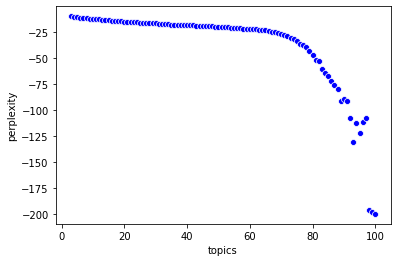

In [53]:
# plot the results - PERPLEXITY
sns.scatterplot(x="topics", y="perplexity", color="blue", data=results)

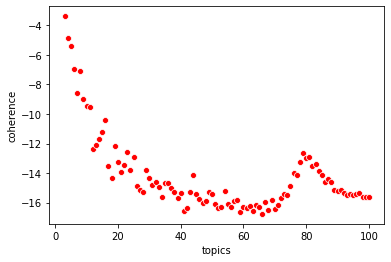

In [54]:
# plot the results - COHERENCE
sns.scatterplot(x="topics", y="coherence", color="red", data=results)

## 4. Create the "best" model using all data

And parameters decided by test-time performance on perplexity and coherence.

For RSS; 62 topics looks good.  Getting suspicious though, got similar answer (~70) for wine descriptions.

In [55]:
random.seed(10)

# Fit the final lda model to all data
lda_model_tfidf = LdaModel(corpus['corpus_tfidf'],
                           num_topics=80,
                           id2word=dictionary,
                           passes=2)

# Get the perplexity, out of curiosity
perplexity = lda_model_tfidf.log_perplexity(corpus['corpus_tfidf'])
    
# Get the coherence, out of curiosity
cm = CoherenceModel(model=lda_model_tfidf, corpus=corpus['corpus_tfidf'], coherence='u_mass')
coherence = cm.get_coherence()

print("perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

lda_model_tfidf.save("working/lda_model_tfidf.model")

perplexity = -49.220332012113744 coherence = -8.62982789631393


In [56]:
# Let's take a quick look at the topics picked out
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.000*"stock" + 0.000*"bond" + 0.000*"whalley" + 0.000*"billington" + 0.000*"southampton" + 0.000*"korean" + 0.000*"tenant" + 0.000*"interrupt" + 0.000*"devis" + 0.000*"supermarket"
Topic: 1 Word: 0.123*"plan" + 0.119*"fear" + 0.101*"develop" + 0.053*"build" + 0.041*"land" + 0.041*"cost" + 0.040*"campaign" + 0.039*"valley" + 0.038*"risk" + 0.037*"grant"
Topic: 2 Word: 0.296*"outbreak" + 0.100*"case" + 0.071*"world" + 0.070*"death" + 0.037*"claim" + 0.035*"long" + 0.035*"allow" + 0.029*"popul" + 0.026*"summer" + 0.023*"avoid"
Topic: 3 Word: 0.107*"centr" + 0.101*"scheme" + 0.087*"scottish" + 0.080*"protect" + 0.044*"capit" + 0.040*"town" + 0.037*"govern" + 0.034*"million" + 0.031*"scotland" + 0.025*"total"
Topic: 4 Word: 0.120*"amid" + 0.100*"storm" + 0.055*"power" + 0.050*"cut" + 0.049*"hurrican" + 0.049*"taken" + 0.047*"half" + 0.030*"face" + 0.028*"wind" + 0.021*"rest"
Topic: 5 Word: 0.106*"food" + 0.067*"industri" + 0.060*"describ" + 0.060*"data" + 0.052*"suppli" + 0.

In [57]:
# Let's take a quick look at words the topics picked out
topic_word_dist = pd.DataFrame()

for idx, topic in lda_model_tfidf.print_topics(-1):
    
    # Record the topic index in a format R will like
    topic_index = "X" + str(idx)
    
    # Record the topic's key words as a single string
    # Split the words with a newline character while we're at it!
    topic_words = " ".join([x.split("*")[1].replace('"', '').strip() for x in topic.split("+")][0:5])
    
    # Dump them to the results dataframe
    topic_word_dist = topic_word_dist.append({"topic":topic_index, "keywords":topic_words}, ignore_index=True)
    
topic_word_dist

,keywords,topic
0,stock bond whalley billington southampton,X0
1,plan fear develop build land,X1
2,outbreak case world death claim,X2
3,centr scheme scottish protect capit,X3
4,amid storm power cut hurrican,X4
...,...,...
75,stock bond whalley billington southampton,X75
76,warn issu statement weather met,X76
77,worker work nurs period reduc,X77
78,stock bond whalley billington southampton,X78


In [58]:
# Assign topic to document, also store the probability of that topic
doc_topics = []

count = 0
for index, row in corpus.iterrows():
    
    # Extract list of tuples of (topic, score) from the model for each doc
    topics = [x for x in lda_model_tfidf.get_document_topics(row['corpus_tfidf']) ]
    
    # Find the highest probability topic
    highest_scoring = sorted(topics, key=lambda x: x[1], reverse=True)[0]
    
    temp = {"node": int(index),
            "cluster": highest_scoring[0],
            "score": highest_scoring[1]}
    
    # Report processing progress!
    count = count + 1
    if count % 10000 == 0:
        print(count)
    
    doc_topics.append(temp)

doc_topic_dist = pd.DataFrame(doc_topics).set_index("node")

doc_topic_dist.to_csv("working/doc_topic_dist_backup.csv")

doc_topic_dist.head()

10000


,cluster,score
node,,
0,11,0.468018
1,11,0.457334
2,4,0.822984
3,33,0.404463
4,10,0.227521


In [59]:
corpus.join(doc_topic_dist).to_csv("working/disaster_clustered_lda.csv")